# REFERENCE - benchmark structural regression

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import matplotlib as mpl
import sys
from math import *
from scipy.stats import binned_statistic
import inspect
from Bio import SeqIO
from pathlib import Path
sns.set_theme(style="white", context="talk")

from utils_benchmark import * 
#test()

In [2]:
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"
seqs_dir = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/refs/"
# Load reference stats 
stats_alignments_ref= pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "stats_alignments_refs.csv"))
summary_homfam_merged_tosave = pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_homfam_with_refs.csv"))

# Extract AF2 info for references only # Load AF2 scores
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")

In [3]:
# Extract all sequences in reference 
summary_ref_af2 = pd.DataFrame()
for f in listdir(seqs_dir):
     if f.endswith("fa"):
        fasta_sequences = SeqIO.parse(open(os.path.join(seqs_dir,f)),'fasta')
        for fasta in fasta_sequences:
            seq_id = [fasta.id.replace("/","_")]
            entry = pd.DataFrame({'sequence': seq_id, "name": [f.replace("-ref.fa","").strip()]})
            summary_ref_af2 =  pd.concat([summary_ref_af2, entry], ignore_index = True)
summary_ref_af2["subset"] = "ref"
summary_ref_af2["family"] = summary_ref_af2.name
summary_ref_af2.name.unique().shape

summary_ref_af2 = summary_ref_af2.merge(af2, on = ["sequence", "family"])
af2_homfam_summary = summary_ref_af2.groupby(['family',"benchmarking_dataset"]).agg({'plddt': ['mean', 'min', 'max']}).reset_index().set_axis(["family", "benchmarking_dataset", "plddt_mean", "plddt_min", "plddt_max"], axis=1)

summary_ref_af2 = summary_ref_af2.merge(af2, on = ["sequence", "family"])
summary_homfam_merged_tosave["family"] = summary_homfam_merged_tosave.familcombined
summary_ref = pd.merge(summary_homfam_merged_tosave,af2_homfam_summary)
summary_ref.head(2)

,familcombined,subset_ref,n_sequences_ref,mean_length_ref,min_length_ref,maref_length_ref,file_ref,subset_combined,n_sequences_combined,mean_length_combined,min_length_combined,maref_length_combined,file_combined,perc_ref_total,family,benchmarking_dataset,plddt_mean,plddt_min,plddt_max
0,Stap_Strp_toxin,ref,6,220.333333,190,238,Stap_Strp_toxin.ref,combined,640,87.392188,20,238,Stap_Strp_toxin,0.937500,Stap_Strp_toxin,homfam,85.608750,83.9390,86.9715
1,sodfe,ref,8,198.500000,186,205,sodfe.ref,combined,4455,77.447138,17,205,sodfe,0.179574,sodfe,homfam,87.783687,86.8641,88.3437


# Check purely references 

In [4]:
metrics = [["sp", "sum of pairs"], ["tc", "total column"], ["column", "column"]]
metrics = [["tc", "total column"]]
sns.set_context("talk")

In [5]:
df = stats_alignments_ref
df.nref = df.n_sequences * df.perc_ref_total /100 

df_dyn = df[df.approach == "dynamic_50.0_tcoffee_msa_famsa_msa_100000000"]
fams = (df_dyn.family.unique())

df_prog = df[(df.approach == "progressive") & (df.family.isin(fams))]
df_reg = df[(df.approach == "regressive_50.0")  & (df.family.isin(fams))]

df_dyn["nref"] = df_dyn.n_sequences * df_dyn.perc_ref_total /100 


df = pd.concat([df_dyn, df_reg, df_prog])

/tmp/ipykernel_8434/3373153524.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.nref = df.n_sequences * df.perc_ref_total /100
/tmp/ipykernel_8434/3373153524.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dyn["nref"] = df_dyn.n_sequences * df_dyn.perc_ref_total /100


In [6]:
df_d_r = pd.merge(df_dyn, df_reg, on = ["family"] )
df_d_r["diff_tc"] = df_d_r.tc_x - df_d_r.tc_y 
df_d_r["diff_sp"] = df_d_r.sp_x - df_d_r.sp_y 
df_d_r["perc_change_tc"]= df_d_r.diff_tc *100/ abs(df_d_r.tc_y) 


# Align reference sequences alone 


## 1: How well do we do?
### Check that structural aligner does better than standard one

In [7]:
df = df[df.method.isin(["dynamic","progressive"])]
df["structure"] = "no_structure"
df.loc[df.method == "dynamic", 'structure'] = "structure"
df

,name,sp,tc,column,Number of sequences,Alignment length,Total # residues,Smallest,Largest,Average length,...,mean_length,min_length,max_length,file,size_group,perc_ref_total,approach,fam_approach,nref,structure
4,ricin-ref.dynamic.50.dynamicX.100000000.tcoffe...,94.8,85.0,90.1,7,285,1783,246,267,254.7,...,198.708166,44,267,ricin,small,0.937082,dynamic_50.0_tcoffee_msa_famsa_msa_100000000,ricin_dynamic_50.0_tcoffee_msa_famsa_msa_10000...,7.0,structure
9,tim-ref.dynamic.50.dynamicX.100000000.tcoffee_...,98.7,92.7,95.6,10,261,2495,246,255,249.5,...,205.645492,23,278,tim,small,0.256148,dynamic_50.0_tcoffee_msa_famsa_msa_100000000,tim_dynamic_50.0_tcoffee_msa_famsa_msa_100000000,10.0,structure
18,flav-ref.dynamic.50.dynamicX.100000000.tcoffee...,93.1,79.4,82.7,6,185,970,138,175,161.7,...,138.021032,33,208,flav,medium,0.130095,dynamic_50.0_tcoffee_msa_famsa_msa_100000000,flav_dynamic_50.0_tcoffee_msa_famsa_msa_100000000,6.0,structure
21,aldosered-ref.dynamic.50.dynamicX.100000000.tc...,96.0,82.2,86.9,7,386,2176,277,325,310.9,...,268.547187,32,453,aldosered,large,0.052723,dynamic_50.0_tcoffee_msa_famsa_msa_100000000,aldosered_dynamic_50.0_tcoffee_msa_famsa_msa_1...,7.0,structure
24,hom-ref.dynamic.50.dynamicX.100000000.tcoffee_...,98.5,81.2,97.1,8,94,508,49,77,63.5,...,53.495140,12,79,hom,large,0.066462,dynamic_50.0_tcoffee_msa_famsa_msa_100000000,hom_dynamic_50.0_tcoffee_msa_famsa_msa_100000000,8.0,structure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,cyt3-ref.progressive.FAMSA.FAMSA-medoid,78.6,48.3,54.0,6,133,660,107,118,110.0,...,92.306494,52,127,cyt3,small,1.558442,progressive,cyt3_progressive,NaN,no_structure
229,DEATH-ref.progressive.FAMSA.FAMSA-medoid,59.2,23.4,28.7,7,165,750,85,150,107.1,...,80.568893,37,150,DEATH,small,0.591716,progressive,DEATH_progressive,NaN,no_structure
232,tms-ref.progressive.FAMSA.FAMSA-medoid,96.3,85.6,91.5,5,355,1425,264,316,285.0,...,264.245042,24,488,tms,small,0.236072,progressive,tms_progressive,NaN,no_structure
241,DMRL_synthase-ref.progressive.FAMSA.FAMSA-medoid,91.1,71.6,82.0,5,173,790,148,168,158.0,...,140.590281,39,168,DMRL_synthase,small,0.238209,progressive,DMRL_synthase_progressive,NaN,no_structure


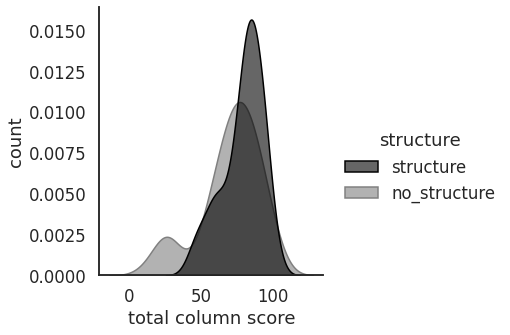

In [8]:
# Set your custom color palette
sns.set_palette(sns.color_palette(["black", "grey"]))
sns.displot(data = df, x="tc", hue = "structure", kind = "kde", fill = "structure", alpha = 0.6).set(xlabel = "total column score", ylabel = "count")

[Text(0, 0.5, 'structure SP - not structure SP'),
 Text(0.5, 0, ''),
 [Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49,

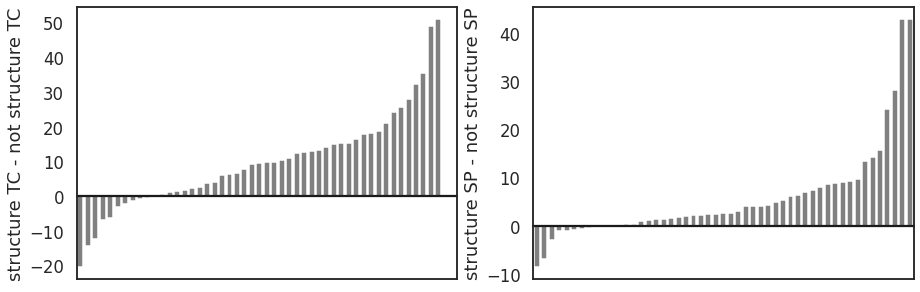

In [9]:
# Set up the matplotlib figure
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

# Center the data to make it diverging
sns.barplot(x=df_d_r.diff_tc, y=df_d_r.diff_tc, color ="grey", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set(ylabel="structure TC - not structure TC", xlabel = "", xticklabels="")

# Center the data to make it diverging
sns.barplot(x=df_d_r.diff_sp, y=df_d_r.diff_sp, color ="grey", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set(ylabel="structure SP - not structure SP", xlabel = "", xticklabels="")

In [10]:
# Which are the ones for which we do not get ? 
family_worst = list(df_d_r[df_d_r.diff_tc < 0].family)
df_d_r["diff_qualitatively"] = "better"
df_d_r.loc[df_d_r.diff_tc < 0, 'diff_qualitatively'] = "worst"
df_d_r.diff_qualitatively.value_counts()
df_d_r = pd.merge(df_d_r, summary_ref, on = "family")

<AxesSubplot:xlabel='diff_qualitatively', ylabel='n_sequences_x'>

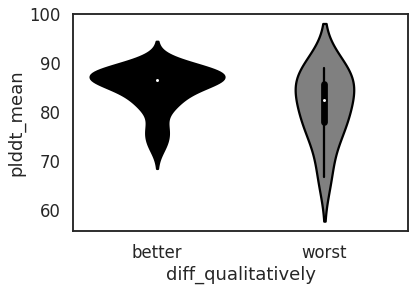

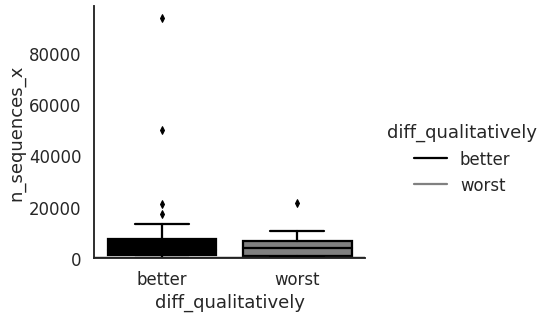

In [11]:
sns.violinplot(data = df_d_r, y = "plddt_mean", x = "diff_qualitatively")
sns.displot(df_d_r, x = "n_sequences_x", hue = "diff_qualitatively", kind = "kde")
sns.boxplot(data = df_d_r, y = "n_sequences_x", x = "diff_qualitatively")


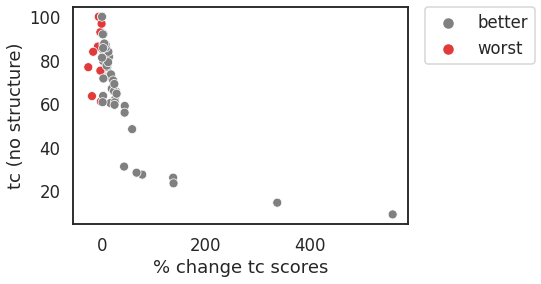

In [13]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, x = "perc_change_tc", y = "tc_y", hue = "diff_qualitatively").set(ylabel = "tc (no structure)", xlabel = "% change tc scores")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


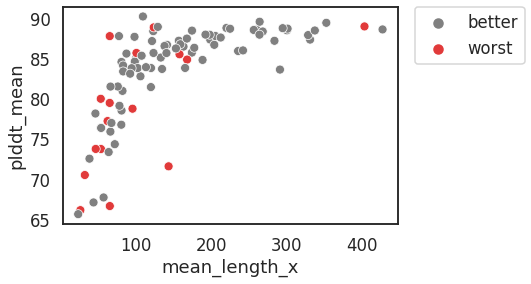

In [31]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, x = "mean_length_x", y = "plddt_mean", hue = "diff_qualitatively")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


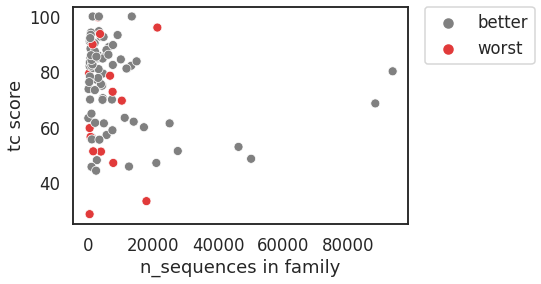

In [32]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, y = "tc_x", x = "n_sequences_x", hue = "diff_qualitatively").set(xlabel  ="n_sequences in family", ylabel = "tc score")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


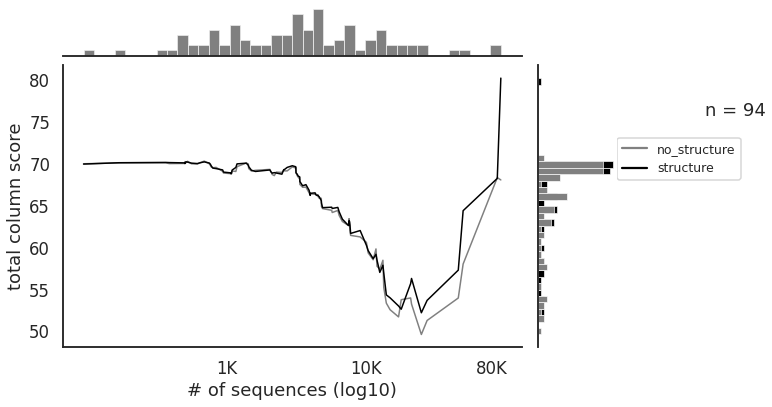

In [33]:
# -------------------------------
#           Plot TC 
# ------------------------------

sns.set_palette(sns.color_palette(["grey", "black"]))

df["n_sequences_log"] = np.log10( df["n_sequences"] )  


x = df.n_sequences_log
y = cumavg(df.sort_values(by=["n_sequences_log"], ascending = False)["tc"])
hue = df["structure"]


ax = sns.JointGrid(x = x, y = y, hue = hue)
ax.plot_joint(sns.lineplot,  linewidth=1.5)
ax.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=40)
ax.ax_joint.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=5.8, fontsize = "x-small")
ax.fig.set_figwidth(10)
ax.fig.set_figheight(6)

ax.ax_joint.set(xlabel = "# of sequences (log10)", ylabel = "total column score")
ax.ax_joint.set_xticks(np.log10([1000,10000,80000]))
ax.ax_joint.set_xticklabels(["1K", "10K", "80K"]) 
plt.title("n = "+str(len(fams)), x=2.5, y=0.8)


outdir = "../../../data/structural_regression/plots/03_benchmarkDynamic/" 
plt.savefig(os.path.join(outdir, "01_seq_vs_tc.pdf"))

# 2: Are the reference sequences of big families more challenging to align even when alone?
### is it dependent on sequence length? 

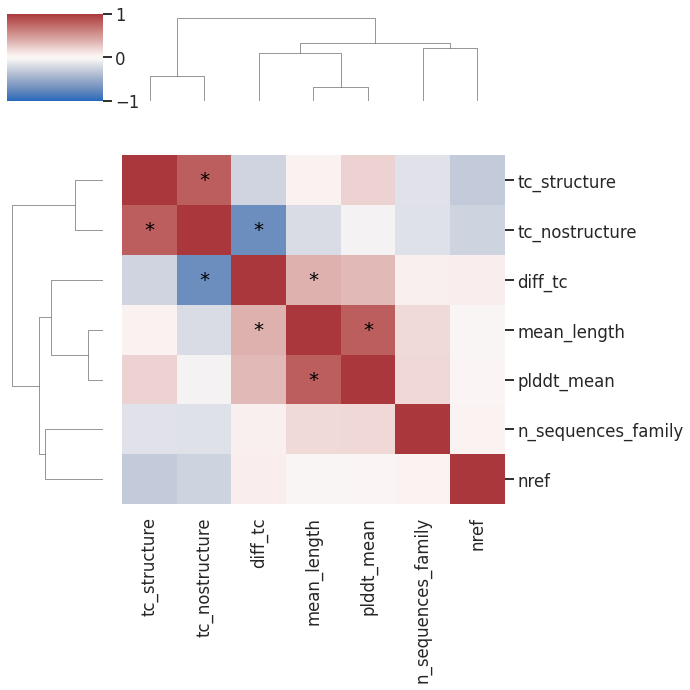

In [655]:
df_correlation = df[["sp","tc", "n_sequences", "nref", "mean_length", "method"]]

df_correlation = df_d_r[["diff_tc","tc_x","tc_y",  "n_sequences_x", "nref_x", "mean_length_x", "plddt_mean"]]

df_correlation.columns = ["diff_tc", "tc_structure", "tc_nostructure", "n_sequences_family", "nref", "mean_length", "plddt_mean"]
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
def get_correlations(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    correlations = dfcols.transpose().join(dfcols, how="outer")
    for ix, r in enumerate(df.columns):
        for jx, c in enumerate(df.columns):
            sp = spearmanr(df[r], df[c])
            correlations[c][r] = sp[0]
            pvalues[c][r] = sp[1] if ix > jx else np.nan  # Only store values below the diagonal
    return correlations.astype("float"), pvalues.astype("float")


correlations, uncorrected_p_values = get_correlations(df_correlation)

# Correct p-values for multiple testing and check significance (True if the corrected p-value < 0.05)
shape = uncorrected_p_values.values.shape
significant_matrix = multipletests(uncorrected_p_values.values.flatten())[0].reshape(
    shape
)

# Here we start plotting
g = sns.clustermap(correlations, cmap="vlag", vmin=-1, vmax=1)

# Here labels on the y-axis are rotated
for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

# Here we add asterisks onto cells with signficant correlations
for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if significant_matrix[ix, jx] or significant_matrix[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

# Save a high-res copy of the image to disk
plt.tight_layout()
plt.savefig("clustermap.png", dpi=200)